# 👋 Welcome Object Detection Tutorial with PUNCC

In this tutorial, we will guide you through the process of uncertainty quantification in object detection using the **puncc** library on the COCO dataset.

By the end of this notebook, you will be able to transform your own models into conformal predictors and evaluate their performance effectively.

-------

**Table of contents**

- [⚙️ Setup](#cr-setup)
    - [DataLoader](#cr-dataloader)
    - [Model API](#cr-modelapi)
- [💾 Dataset](#cr-data)
- [🔮 Model API](#cr-pm)
- [🖼️ Conformal Object Detection](#cr-cod)

**Links**
- [<img src="https://github.githubassets.com/images/icons/emoji/octocat.png" width=20> Github](https://github.com/deel-ai/puncc)
- [📘 Documentation](https://deel-ai.github.io/puncc/index.html)

### ⚙️ Setup  <a class="anchor" id="cr-setup"></a>

First, ensure we have the necessary libraries installed. You can install them if needed using pip:

In [1]:
# !pip install puncc transformers

We import the general-purpose modules that will be used throughout the tutorial:

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
import numpy as np
import seaborn as sns
from PIL import Image
import requests
import pickle
from tqdm import tqdm
from itertools import compress
import os
import json
from sklearn.model_selection import train_test_split

sns.set_theme()

warnings.filterwarnings("ignore")

#### ⚙️ DataLoader <a class="anchor" id="cr-dataloader"></a>

We will work with the COCO dataset (details to be presented later). You don't need to download the entire dataset beforehand, as we will handle it dynamically.

We define a dataloader that is responsible for downloading the data, associating features $X$ with their labels $y$, and splitting the dataset into multiple subsets. While you don't need to fully understand the code, it's important to know that an instance of this class can generate subsets from the COCO dataset based on the [**annotation file**](https://cocodataset.org/#download) provided during initialization.  

In [3]:
from torch.utils.data import Dataset

# Coco Dataset class
class CocoDataset(Dataset):
    def __init__(self, annotations_path, shuffle=True):
        URL_TYPE = "coco_url"
        self.annotations_path = annotations_path
        # Load the annotations
        with open(annotations_path, "r") as f:
            coco_annotations = json.load(f)
            # list of dicts with the keys: ['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id']
            self.image_infos = coco_annotations["images"]
            # list of dicts with the keys: ['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id']
            self.image_annotations = coco_annotations["annotations"] 
            # class classes
            self.classes = coco_annotations["categories"]
        # Extract the flickr urls from the annotations  
        self.image_urls = [image[URL_TYPE] for image in self.image_infos]
        if shuffle:
            np.random.shuffle(self.image_urls) # shuffle the flickr urls
        
        # Create a mapping from category ids to category names
        self.categoryid2name = {category["id"]: category["name"] for category in self.classes}
        # Create a mapping from flickr urls to image ids
        self.url2imageid = {image[URL_TYPE]: image["id"] for image in self.image_infos}
        # Create a mapping from image ids to bboxes (annotations)
        self.imageid2bbox = {image_id: [] for image_id in np.unique([annotation["image_id"] for annotation in self.image_annotations])}
        # Create a mapping from image ids to category names
        self.imageid2class = {image_id: [] for image_id in np.unique([annotation["image_id"] for annotation in self.image_annotations])}
        
        # remove urls that do not have annotations
        self.image_urls = [url for url in self.image_urls if self.url2imageid[url] in self.imageid2bbox]
        
        # Format the annotations 
        self._prepare_annotations()

    def _prepare_annotations(self):
        for annotation in self.image_annotations:
            # Format the annotation and append it to the list of bboxes
            self.imageid2bbox[annotation["image_id"]].append(self._format_annotation(annotation["bbox"]))
            self.imageid2class[annotation["image_id"]].append(self.categoryid2name[annotation["category_id"]])

    def _format_annotation(self, annotation):
        # Annotation is in the format [x, y, width, height]
        # Format it to be in the format [x1, y1, x2, y2]
        # where (x1, y1) is the top-left corner and (x2, y2) is the bottom-right 
        # corner of the bounding box
        annotation[2] += annotation[0]
        annotation[3] += annotation[1]
        return annotation
    
    def _download_image(self, url):
        # Download the image using the url
        # response = requests.get(url)
        # img_data = response.content
        # image = Image.open(BytesIO(img_data)) # Open the image using PIL
        image = Image.open(requests.get(url, stream=True).raw)
        return image

    def __len__(self):
        return len(self.image_urls)
    
    def __getitem__(self, idx):
        # Get the image url
        return self.getbyindex(idx)
    
    def getbyindex(self, idx):
        # Get the image url
        url = self.image_urls[idx]
        # Get the image id
        image_id = self.url2imageid[url]
        # Get the bboxes for the image
        bboxes = self.imageid2bbox[image_id]
        # Get the classes for the image
        classes = self.imageid2class[image_id]
        # Download the image
        image = self._download_image(url)
        return image, bboxes, classes
    
    # write a function to split the dataset into calibration and test sets 
    def split(self, test_size=0.8, random_state=42):
        # Split the dataset into calibration and test sets
        calib_urls, test_urls = train_test_split(self.image_urls, 
                                                 test_size=test_size, 
                                                 random_state=random_state)
        # Create the calibration and test datasets
        calib_dataset = CocoDataset(self.annotations_path)
        calib_dataset.image_urls = calib_urls
        test_dataset = CocoDataset(self.annotations_path)
        test_dataset.image_urls = test_urls
        print(f"Calibration dataset size: {len(calib_dataset)}")
        print(f"Test dataset size: {len(test_dataset)}")
        return calib_dataset, test_dataset

#### Setup - Model API <a class="anchor" id="cr-modelapi"></a>


We define the `ObjectDetectionAPI`, a class that allows querying a number of instances of images and their object detection labels (bounding boxes and associated classes). An instance of this class will load the pre-trained DEtection TRansformer (DETR) model (`detr-resnet-50`) and its image processor from the transformers library.

An important method of the class is `predict_bounding_boxes`, which takes an image as input, preprocesses it, and then applies the object detection model to get bounding box predictions. Another key method is `query`, which retrieves the predicted bounding boxes for a batch of images along with the associated true bounding boxes and classes. The matching between predicted and ground truth bounding boxes is performed using the Hungarian assignment algorithm, considering a minimum IoU and ignoring false positives. The `query` method takes as inputs a dataset (returned by `CocoDataset`) and the number of instances constituting the batch of images.

In [4]:
import torch
from deel.puncc.api.utils import hungarian_assignment
from transformers import DetrImageProcessor, DetrForObjectDetection

class ObjectDetectionAPI:
    def __init__(self):
        # Initialize the DETR model and processor from pretrained weights
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
        self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
        self.file_path = "calibration_data.pickle"  # Path to save/load calibration data

    def predict_from_image(self, image):
        # Preprocess the image and make predictions using the model
        inputs = self.processor(images=image, return_tensors="pt")
        outputs = self.model(**inputs)
        target_sizes = torch.tensor([image.size[::-1]])  # Get the size of the image
        bboxes_per_image = self.processor.post_process_object_detection(outputs, 
                                                                        target_sizes=target_sizes, 
                                                                        threshold=0.9)[0]
        y_preds_per_image = bboxes_per_image["boxes"].detach().numpy()  # Extract bounding boxes
        return y_preds_per_image

    def predict_and_match(self, image, y_trues_per_image):
        # Predict bounding boxes and match them with true bounding boxes using the Hungarian algorithm
        y_preds_per_image = self.predict_from_image(image)
        y_preds_i, y_trues_i, indices_i = hungarian_assignment(np.array(y_preds_per_image), 
                                                               np.array(y_trues_per_image), 
                                                               min_iou=0.4)
        return y_preds_i, y_trues_i, indices_i

    def load_results(self):
        # Load previously saved results from a file
        with open(self.file_path, "rb") as file:
            results_dict = pickle.load(file)
            return (results_dict["y_preds"], results_dict["y_trues"], 
                    results_dict["images"], results_dict["labels"])
            
    def save_results(self, y_preds, y_trues, images, labels):
        # Save results to a file
        with open(self.file_path, "wb") as file:
            pickle.dump({"y_preds": y_preds, "y_trues": y_trues, "images": images, "labels": labels}, file)

    def query(self, dataset, n_instances=None):
        # Initialize lists to store predictions, true labels, images, and classes
        y_preds, y_trues, images, classes = [], [], [], []
        
        #Check if the file at self.file_path exists
        if os.path.exists(self.file_path):
            y_preds, y_trues, images, labels = self.load_results()
            return y_preds, y_trues, images, labels
        
        # Iterate over the dataset and predict on each image
        for counter, (image, y_trues_per_image, labels) in enumerate(tqdm(dataset), start=1):
            y_preds_i, y_trues_i, indices_i = self.predict_and_match(image, y_trues_per_image)
            y_preds.append(y_preds_i)
            y_trues.append(y_trues_i)
            classes.append(list(compress(labels, indices_i)))
            images.append(image)

            # Break the loop if n_instances is provided
            if n_instances is not None and counter == n_instances:
                break

        # Concatenate the lists into arrays
        y_preds = np.concatenate(y_preds)
        y_trues = np.concatenate(y_trues)
        classes = np.concatenate(classes)

        # Save the results
        # self.save_results()

        return y_preds, y_trues, images, classes

2024-09-04 11:47:42.209329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 11:47:42.209381: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 11:47:42.215126: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 11:47:42.816947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 11:47:45.485011: W tensorflow/compiler/

### 💾 Dataset <a class="anchor" id="cr-data"></a>

COCO (Common Objects in Context) dataset is a widely used benchmark dataset for object detection. It consists of a large collection of images with detailed annotations, including bounding boxes and object classes. The dataset covers a wide range of object categories and provides a diverse set of images captured in various contexts.

The annotations in the dataset provide ground truth information that can be used to train and evaluate the performance of object detection models. In our scenario, we assume the object detection model is already in production and accessible through an API, so there is no need for training samples. Instead, we will focus on data for **calibration**, as part of the conformal prediction procedure, and a **test** dataset to evaluate the performance of uncertainty quantification in object detection.

We will use a portion of the 2017 validation data for calibration and the remainder for testing. The annotations configuration file, which provides the image URLs and associated labels, can be downloaded from the [COCO website](https://cocodataset.org/#download). For simplicity, we have included this file as part of the tutorial.

In [5]:
# Annotations config path
annotations_path = "assets/instances_val2017.json"
# Load the validation dataset
dataset = CocoDataset(annotations_path, shuffle=True)
# Split the dataset into calibration and test subsets
calib_dataset, test_dataset = dataset.split(test_size=0.95)

Calibration dataset size: 247
Test dataset size: 4705


### 🔮 Prediction Model <a class="anchor" id="cr-pm"></a>

We are working with an object detection model that is already in production and accessible only through API requests (i.e., we don't have direct access to the model instance). Let's create an instance of the API, which we will use later to query the model and obtain bounding box predictions for images:

In [6]:
# create an instance of the API
object_detection_api = ObjectDetectionAPI()

### 🖼️ Conformal Object Detection <a class="anchor" id="cr-cod"></a>

The figure below summarizes our scenario: 

<div align=center>
<img src="assets/uc_object_detection.png" width="800"> </img>
</div>

From our perspective, the predictions served through the API are generated by an unknown model that is not directly accessible. However, we can still apply conformal prediction techniques to it!

Although we don't have a model object to wrap, we can create a proxy using *puncc* using [`IdPredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.IdPredictor).

In [7]:
from deel.puncc.api.prediction import IdPredictor

# Create the proxy of object detection model
api_model = IdPredictor()

Now we are ready to perform conformal object detection on COCO. The following code snippet is the template we will follow to implement our conformal object detector !

<div align=center>
<img src="assets/object_detection.png" width="800"> </img>
</div>

We define an instance of the conformal predictor `SplitBoxWise`. Make sure the argument `train` is set to False, as the model is already trained:

In [8]:
from deel.puncc.object_detection import SplitBoxWise

# Instantiate conformal predictor
api_cp = SplitBoxWise(api_model, train=False)

Retrieve predictions and labels for 150 instances of the calibration data using the model's API. This data will be used to calibrate the model.

In [10]:
# get calibration data through API
y_calib_api, y_calib_coco, calib_images, calib_labels = object_detection_api.query(calib_dataset, n_instances = 150)

 60%|██████    | 149/247 [03:28<02:17,  1.40s/it]


Now we can fit our conformal predictor. The non-conformity scores are computed and stored within the conformal prediction object.

In [11]:
# Fit conformal predictor
api_cp.fit(X_calib=y_calib_api, y_calib=y_calib_coco)

We first choose an new image and send a request to the API to get the point prediction:

In [37]:
# Select an image from the test dataset
image, bboxes, classes = test_dataset[1]

# Predict on the image
y_new_api = object_detection_api.predict_from_image(image)

**Conformal Inference** 

Finally, we can infer the uncertainty of the model on an example using our conformal predictor. We have to set a level of risk $\alpha$ that is acceptable for us.

In [38]:
# Choose the coverage target 1-alpha
alpha = 0.3

# Inference + UQ
y_pred_new, box_inner, box_outer = api_cp.predict(y_new_api, alpha=alpha)

Let's visualize the results:

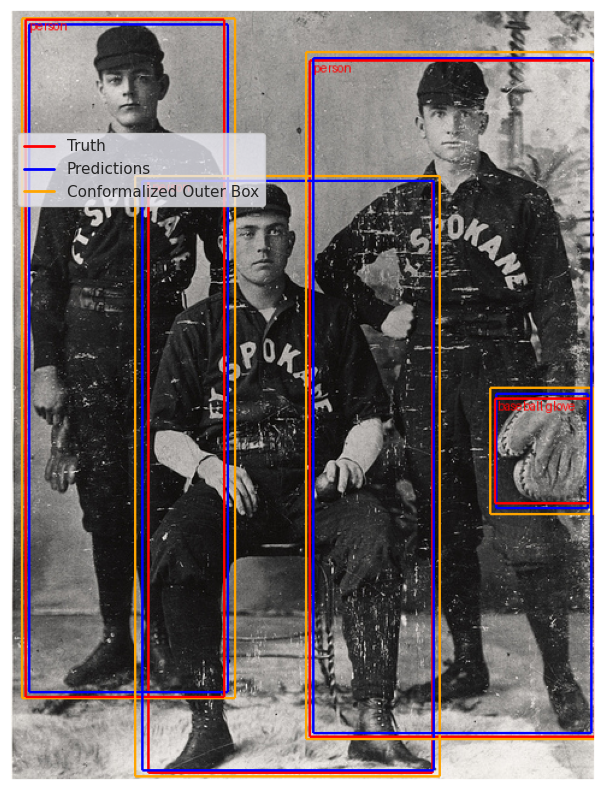

In [39]:
from deel.puncc.plotting import draw_bounding_box

image_with_bbox = image.copy()

for i in range(len(y_pred_new)):
    image_with_bbox = draw_bounding_box(
        image=image_with_bbox,
        box=bboxes[i],
        label=classes[i],
        legend="Truth",
        color="red",
    )
    image_with_bbox = draw_bounding_box(
        image=image_with_bbox,
        box=y_pred_new[i],
        legend="Predictions",
        color="blue",
    )
    image_with_bbox = draw_bounding_box(
        image=image_with_bbox,
        box=box_outer[i],
        legend="Conformalized Outer Box",
        color="orange",
    )
    
    # image_with_bbox = draw_bounding_box(
    #     image=image_with_bbox,
    #     box=box_inner[i],
    #     legend="Conformalized Inner Box",
    #     color="brown",
    # )

_ = draw_bounding_box(image=image_with_bbox, show=True)

# 🎉 Congratulations
**You can now conformalize you own object detection models with *puncc***.